# ORF recognition by Convolutional/Recurrent

So far CNN+LSTM 64 overfits the 128 base RNA problem.
That was using 32K samples/class. Here, try more samples. 

Also, build the model without specifying INPUT_SIZE.



In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-27 12:43:37 UTC'

In [2]:
PC_SEQUENCES=64000   # how many protein-coding sequences
NC_SEQUENCES=64000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=128            # how long is each sequence
CDS_LEN=64            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 64   # how many different patterns the model looks for
CELLS = 64
NEURONS = 64
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 30 trials to reach 10 per class.
It took 257005 trials to reach 65000 per class.
Use 65000 PC seqs
Use 65000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 128.0
Average ORF length: 81.15110769230769
NC seqs
Average RNA length: 128.0
Average ORF length: 28.95083076923077


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    #dnn.build(input_shape=INPUT_SHAPE)   
    dnn.build()   
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (128, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 64)           832       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 64)            33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)        

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 59s 10ms/step - loss: 0.6956 - accuracy: 0.5231 - val_loss: 0.6323 - val_accuracy: 0.6426


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.6326 - accuracy: 0.6403 - val_loss: 0.5900 - val_accuracy: 0.6827


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5826 - accuracy: 0.6870 - val_loss: 0.5660 - val_accuracy: 0.6943


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5638 - accuracy: 0.6987 - val_loss: 0.5587 - val_accuracy: 0.6954


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5598 - accuracy: 0.7018 - val_loss: 0.5614 - val_accuracy: 0.7023


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5504 - accuracy: 0.7095 - val_loss: 0.5695 - val_accuracy: 0.6941
Epoch 7/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5540 - accuracy: 0.7049 - val_loss: 0.5545 - val_accuracy: 0.6947
Epoch 8/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5423 - accuracy: 0.7122 - val_loss: 0.5434 - val_accuracy: 0.7075


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5420 - accuracy: 0.7161 - val_loss: 0.5442 - val_accuracy: 0.7056
Epoch 10/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5279 - accuracy: 0.7256 - val_loss: 0.6962 - val_accuracy: 0.4994
Epoch 11/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.6400 - accuracy: 0.6223 - val_loss: 0.4466 - val_accuracy: 0.7971


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.3159 - accuracy: 0.8634 - val_loss: 0.3042 - val_accuracy: 0.8723


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.4232 - accuracy: 0.7962 - val_loss: 0.6129 - val_accuracy: 0.6559
Epoch 14/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.6020 - accuracy: 0.6621 - val_loss: 0.6205 - val_accuracy: 0.6528
Epoch 15/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5955 - accuracy: 0.6749 - val_loss: 0.5718 - val_accuracy: 0.6900
Epoch 16/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5640 - accuracy: 0.6969 - val_loss: 0.5499 - val_accuracy: 0.7045
Epoch 17/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.4589 - accuracy: 0.7636 - val_loss: 0.5209 - val_accuracy: 0.7443
Epoch 18/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.4003 - accuracy: 0.8003 - val_loss: 0.2000 - val_accuracy: 0.9070


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.2428 - accuracy: 0.8921 - val_loss: 0.2067 - val_accuracy: 0.9023
Epoch 20/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.2583 - accuracy: 0.8826 - val_loss: 0.1921 - val_accuracy: 0.9096


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.2598 - accuracy: 0.8700 - val_loss: 0.5745 - val_accuracy: 0.6873
Epoch 22/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5681 - accuracy: 0.6977 - val_loss: 0.5698 - val_accuracy: 0.7054
Epoch 23/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.4147 - accuracy: 0.8033 - val_loss: 0.1790 - val_accuracy: 0.9194


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.2297 - accuracy: 0.8946 - val_loss: 0.1557 - val_accuracy: 0.9264


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.2512 - accuracy: 0.8784 - val_loss: 0.1743 - val_accuracy: 0.9183
Epoch 26/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1629 - accuracy: 0.9253 - val_loss: 0.1442 - val_accuracy: 0.9322


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.6033 - accuracy: 0.6169 - val_loss: 0.1812 - val_accuracy: 0.9197
Epoch 28/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1620 - accuracy: 0.9291 - val_loss: 0.1379 - val_accuracy: 0.9367


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1764 - accuracy: 0.9175 - val_loss: 0.1431 - val_accuracy: 0.9351
Epoch 30/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.1586 - accuracy: 0.9312 - val_loss: 0.1275 - val_accuracy: 0.9402


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.1222 - accuracy: 0.9454 - val_loss: 0.1236 - val_accuracy: 0.9453


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.1608 - accuracy: 0.9208 - val_loss: 0.6221 - val_accuracy: 0.6543
Epoch 33/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5974 - accuracy: 0.6772 - val_loss: 0.2327 - val_accuracy: 0.9012
Epoch 34/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.1794 - accuracy: 0.9198 - val_loss: 0.2474 - val_accuracy: 0.8892
Epoch 35/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.2103 - accuracy: 0.9059 - val_loss: 0.1601 - val_accuracy: 0.9259
Epoch 36/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5247 - accuracy: 0.6645 - val_loss: 0.5058 - val_accuracy: 0.7438
Epoch 37/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5815 - accuracy: 0.6877 - val_loss: 0.5606 - val_accuracy: 0.6992
Epoch 38/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.4446 - accuracy: 0.7740 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1924 - accuracy: 0.9119 - val_loss: 0.1032 - val_accuracy: 0.9522


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 47/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1159 - accuracy: 0.9471 - val_loss: 0.3565 - val_accuracy: 0.8418
Epoch 48/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1460 - accuracy: 0.9367 - val_loss: 0.1206 - val_accuracy: 0.9455
Epoch 49/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1085 - accuracy: 0.9510 - val_loss: 0.2952 - val_accuracy: 0.8692
Epoch 50/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.1666 - accuracy: 0.9270 - val_loss: 0.0997 - val_accuracy: 0.9540


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 51/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.2070 - accuracy: 0.9030 - val_loss: 0.1116 - val_accuracy: 0.9488
Epoch 52/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0948 - accuracy: 0.9567 - val_loss: 0.0878 - val_accuracy: 0.9606


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 53/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0993 - accuracy: 0.9576 - val_loss: 0.1081 - val_accuracy: 0.9528
Epoch 54/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.1848 - accuracy: 0.9117 - val_loss: 0.1088 - val_accuracy: 0.9531
Epoch 55/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1785 - accuracy: 0.9225 - val_loss: 0.2080 - val_accuracy: 0.9068
Epoch 56/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1786 - accuracy: 0.9252 - val_loss: 0.0863 - val_accuracy: 0.9649


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 57/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0812 - accuracy: 0.9676 - val_loss: 0.0789 - val_accuracy: 0.9681


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 58/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.3055 - accuracy: 0.8416 - val_loss: 0.6168 - val_accuracy: 0.6562
Epoch 59/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.6041 - accuracy: 0.6679 - val_loss: 0.5342 - val_accuracy: 0.7257
Epoch 60/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.4470 - accuracy: 0.7864 - val_loss: 0.4834 - val_accuracy: 0.7662
Epoch 61/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.2844 - accuracy: 0.8745 - val_loss: 0.5600 - val_accuracy: 0.7128
Epoch 62/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.4017 - accuracy: 0.8134 - val_loss: 0.1828 - val_accuracy: 0.9218
Epoch 63/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.2933 - accuracy: 0.8611 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 64/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.6863 - accuracy: 0.5398 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 77/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0802 - accuracy: 0.9688 - val_loss: 0.0687 - val_accuracy: 0.9710


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 78/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0766 - accuracy: 0.9700 - val_loss: 0.0756 - val_accuracy: 0.9697
Epoch 79/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0790 - accuracy: 0.9702 - val_loss: 0.0774 - val_accuracy: 0.9728


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 80/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0678 - accuracy: 0.9765 - val_loss: 0.0504 - val_accuracy: 0.9815


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 81/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.3202 - accuracy: 0.8293 - val_loss: 0.5340 - val_accuracy: 0.7323
Epoch 82/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.4825 - accuracy: 0.7655 - val_loss: 0.2135 - val_accuracy: 0.9135
Epoch 83/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.2092 - accuracy: 0.9179 - val_loss: 0.1463 - val_accuracy: 0.9359
Epoch 84/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1468 - accuracy: 0.9380 - val_loss: 0.1423 - val_accuracy: 0.9463
Epoch 85/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1187 - accuracy: 0.9531 - val_loss: 0.1145 - val_accuracy: 0.9534
Epoch 86/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1586 - accuracy: 0.9363 - val_loss: 0.3122 - val_accuracy: 0.8774
Epoch 87/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.2301 - accuracy: 0.9113 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 91/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0830 - accuracy: 0.9705 - val_loss: 0.0581 - val_accuracy: 0.9791
Epoch 92/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0555 - accuracy: 0.9805 - val_loss: 0.0494 - val_accuracy: 0.9819
Epoch 93/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0800 - accuracy: 0.9756 - val_loss: 0.0511 - val_accuracy: 0.9822
Epoch 94/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.0444 - accuracy: 0.9844 - val_loss: 0.0441 - val_accuracy: 0.9838


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 95/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0399 - accuracy: 0.9864 - val_loss: 0.0456 - val_accuracy: 0.9838


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 96/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0506 - accuracy: 0.9841 - val_loss: 0.1070 - val_accuracy: 0.9624
Epoch 97/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0798 - accuracy: 0.9739 - val_loss: 0.0470 - val_accuracy: 0.9840


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 98/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.1170 - accuracy: 0.9608 - val_loss: 0.0644 - val_accuracy: 0.9802
Epoch 99/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.0480 - accuracy: 0.9830 - val_loss: 0.5891 - val_accuracy: 0.6943
Epoch 100/100
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5853 - accuracy: 0.6924 - val_loss: 0.1071 - val_accuracy: 0.9672
Fold 1, 100 epochs, 2918 sec


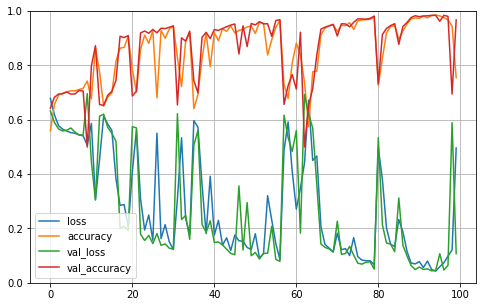

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 31s 10ms/step - loss: 0.6962 - accuracy: 0.5322 - val_loss: 0.6334 - val_accuracy: 0.6381
Epoch 2/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.6237 - accuracy: 0.6475 - val_loss: 0.5700 - val_accuracy: 0.6933
Epoch 3/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5765 - accuracy: 0.6885 - val_loss: 0.5579 - val_accuracy: 0.6981
Epoch 4/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5697 - accuracy: 0.6907 - val_loss: 0.5572 - val_accuracy: 0.7006
Epoch 5/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5561 - accuracy: 0.7037 - val_loss: 0.5569 - val_accuracy: 0.7022
Epoch 6/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5589 - accuracy: 0.7019 - val_loss: 0.5517 - val_accuracy: 0.7053
Epoch 7/100
2667/2667 [==============================] - 27s 10ms/step - loss

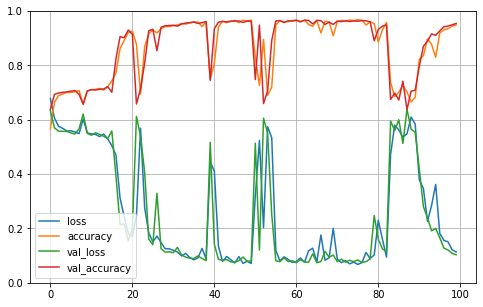

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 32s 11ms/step - loss: 0.6872 - accuracy: 0.5437 - val_loss: 0.6181 - val_accuracy: 0.6549
Epoch 2/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.6025 - accuracy: 0.6713 - val_loss: 0.5873 - val_accuracy: 0.6844
Epoch 3/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5713 - accuracy: 0.6923 - val_loss: 0.5750 - val_accuracy: 0.6886
Epoch 4/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5643 - accuracy: 0.6976 - val_loss: 0.5687 - val_accuracy: 0.6928
Epoch 5/100
2667/2667 [==============================] - 28s 10ms/step - loss: 0.5584 - accuracy: 0.7004 - val_loss: 0.5580 - val_accuracy: 0.6980
Epoch 6/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5514 - accuracy: 0.7052 - val_loss: 0.5554 - val_accuracy: 0.7021
Epoch 7/100
2667/2667 [==============================] - 27s 10ms/step - loss

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 73/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5030 - accuracy: 0.6817 - val_loss: 0.6212 - val_accuracy: 0.6603
Epoch 74/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5978 - accuracy: 0.6712 - val_loss: 0.5880 - val_accuracy: 0.6795
Epoch 75/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5823 - accuracy: 0.6864 - val_loss: 0.5955 - val_accuracy: 0.6768
Epoch 76/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5813 - accuracy: 0.6814 - val_loss: 0.5857 - val_accuracy: 0.6750
Epoch 77/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5653 - accuracy: 0.6916 - val_loss: 0.5783 - val_accuracy: 0.6879
Epoch 78/100
2667/2667 [==============================] - 27s 10ms/step - loss: 0.5711 - accuracy: 0.6909 - val_loss: 0.5591 - val_accuracy: 0.6994
Epoch 79/100
2667/2667 [==============================] - 28s 10ms/step - loss: 0.5337 - accuracy: 0.7229 - val_

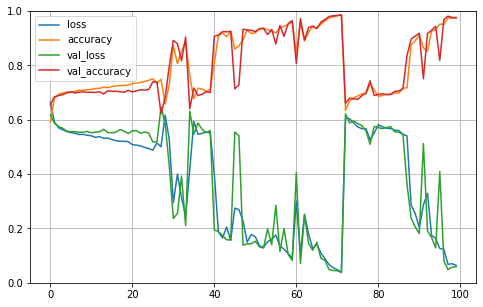

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 98.60%


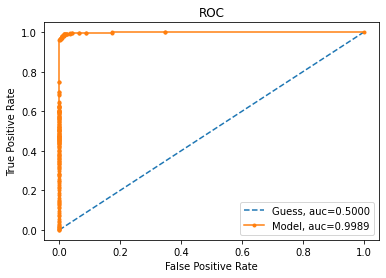

AUC: 99.89%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-27 15:04:43 UTC'